Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# Example of using `tensor_tracker` to visualise the evolution of hidden state through a transformer

1. Download a pretrained transformer model from HuggingFace.
2. Use `tensor_tracker.track(include=...)` to collect specific hidden states from the model.
3. Run a single forward & backward pass.
4. Use UMAP to visualise the extracted results.

In [ ]:
%pip install matplotlib transformers umap-learn

In [1]:
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import transformers
import torch
import umap

import tensor_tracker

In [4]:
model = transformers.AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-410m")
tokenizer = transformers.AutoTokenizer.from_pretrained(model.config._name_or_path)

# Attention Is All You Need, https://arxiv.org/abs/1706.03762
text = """
The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train.
"""

with tensor_tracker.track(model, include=r"(\.\d+|embed_in)$") as tracker:
    inputs = tokenizer([text], return_tensors="pt")
    out = model(**inputs, labels=inputs.input_ids)
    out.loss.backward()

print("forward", [t.name for t in tracker if not t.grad][:5], "...")
print("backward", [t.name for t in tracker if t.grad][:5], "...")
tokens = [[t.replace("Ġ", " ") for t in tokenizer.convert_ids_to_tokens(seq)] for seq in inputs.input_ids]
print("tokens", tokens)

# Shape: (batch, token, layer, hidden_dim)
hiddens = torch.stack([t.value[0].reshape(1, 92, 1024) for t in tracker if not t.grad], -2)
grads = torch.stack([t.value[0].reshape(1, 92, 1024) for t in tracker if t.grad][::-1], -2)
print("hiddens.shape", tuple(hiddens.shape))

forward ['gpt_neox.embed_in', 'gpt_neox.layers.0', 'gpt_neox.layers.1', 'gpt_neox.layers.2', 'gpt_neox.layers.3'] ...
backward ['gpt_neox.layers.23', 'gpt_neox.layers.22', 'gpt_neox.layers.21', 'gpt_neox.layers.20', 'gpt_neox.layers.19'] ...
tokens [['Ċ', 'The', ' dominant', ' sequence', ' transduction', ' models', ' are', ' based', ' on', ' complex', ' recurrent', ' or', ' convolution', 'al', ' neural', ' networks', ' in', ' an', ' encoder', '-', 'decoder', ' configuration', '.', ' The', ' best', ' performing', ' models', ' also', ' connect', ' the', ' encoder', ' and', ' decoder', ' through', ' an', ' attention', ' mechanism', '.', ' We', ' propose', ' a', ' new', ' simple', ' network', ' architecture', ',', ' the', ' Trans', 'former', ',', ' based', ' solely', ' on', ' attention', ' mechanisms', ',', ' dispensing', ' with', ' recurrence', ' and', ' conv', 'olutions', ' entirely', '.', ' Experiments', ' on', ' two', ' machine', ' translation', ' tasks', ' show', ' these', ' models', 

## Visualising the results

Train separate UMAP transforms for the hidden states and gradients, then show how hidden state evolves through the layers of the network. Note that this seems reasonable for residual networks such as the transformer, as there will be correlation between the states after each residual layer.

In [5]:
u = umap.UMAP(metric="cosine", n_neighbors=50, random_state=23875, n_jobs=1)
hiddens_embedding = u.fit_transform(hiddens.flatten(end_dim=-2)).reshape(hiddens.shape[:-1] + (2,))
grads_embedding = u.fit_transform(grads.flatten(end_dim=-2)).reshape(grads.shape[:-1] + (2,))

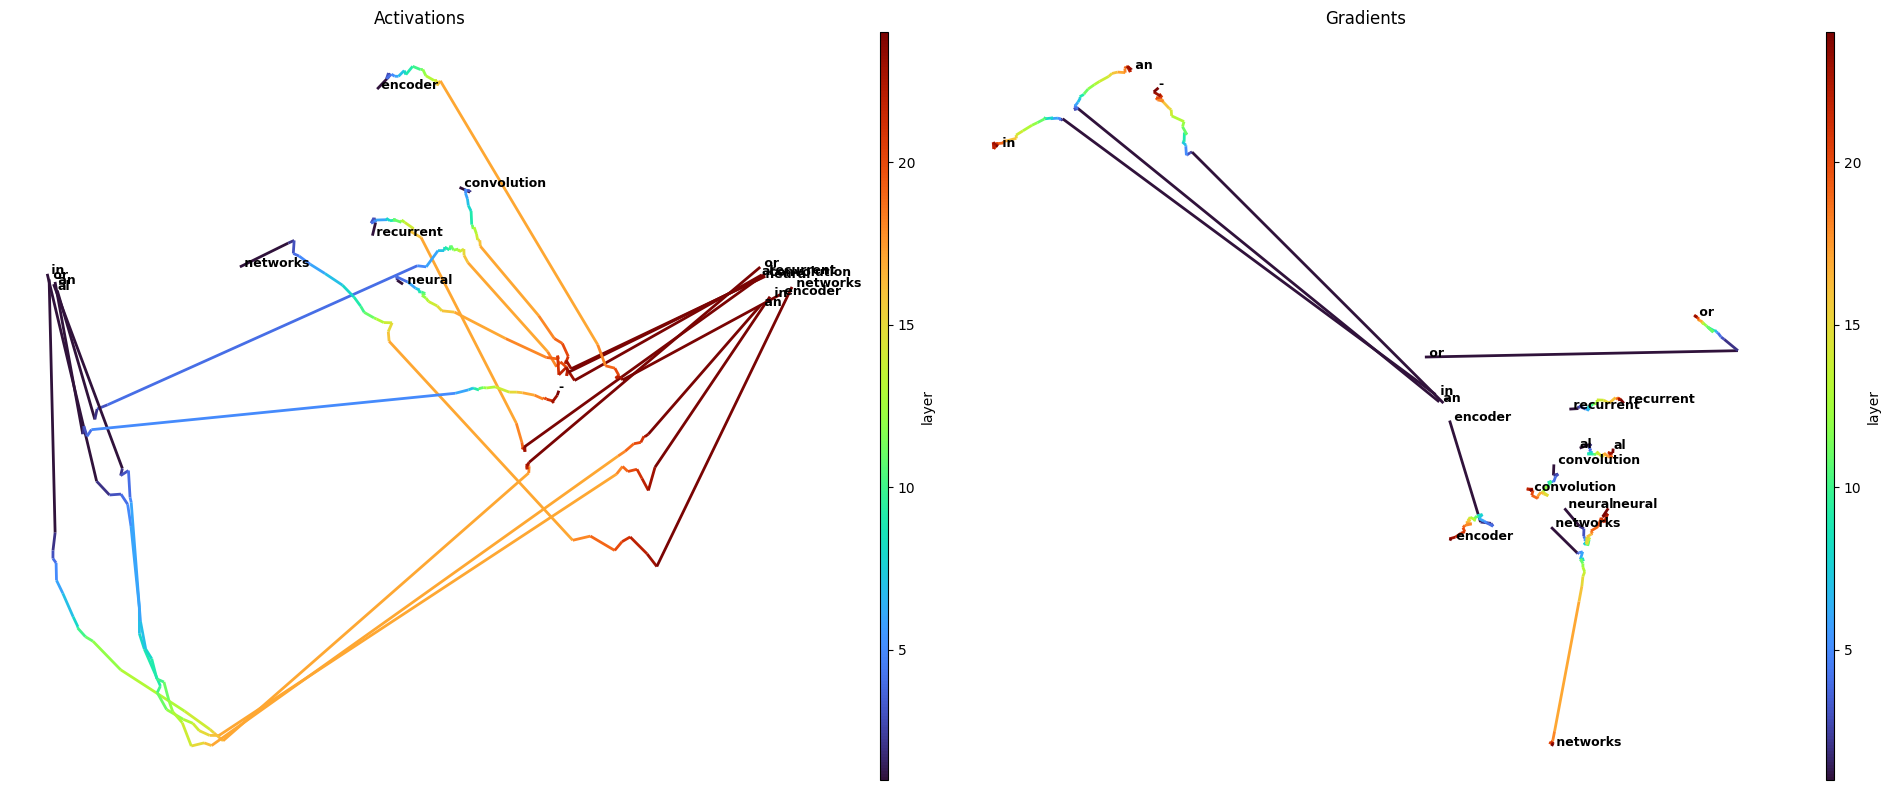

In [6]:
def show_trajectories(embeddings: np.ndarray, tokens: List[str], ax: matplotlib.axes.Axes) -> None:
    for w, token in zip(embeddings, tokens):
        ax.annotate(token, w[0], fontsize=9, fontweight="bold")
        ax.annotate(token, w[-1], fontsize=9, fontweight="bold")
        c = matplotlib.collections.LineCollection(
            np.stack([w[:-1], w[1:]], -2),
            array=np.arange(1, w.shape[0]),
            linewidth=2,
            cmap="turbo",
        )
        ax.add_collection(c)
    ax.autoscale()
    ax.axis("off")
    plt.colorbar(c, ax=ax, aspect=100, label="layer")
    plt.tight_layout()

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))
span = slice(10, 20)
show_trajectories(hiddens_embedding[0, span], tokens[0][span], ax=ax0)
ax0.set_title("Activations")
show_trajectories(grads_embedding[0, span], tokens[0][span], ax=ax1)
ax1.set_title("Gradients");